# Predictive Maintenance using ML and AI
### Step 1. Preparing the data (cleanup the excel sheet)


In [9]:
import pandas as pd
import numpy as np

# Load Excel (header at row 2)
df = pd.read_excel(
    "dataset/faults/LocoFault_Data_38616_04042025_135209PART1.XLSX",
    sheet_name="SHEET",
    header=2,
)

In [10]:
# Clean column names and keep relevant columns
df.rename(columns=lambda x: str(x).strip(), inplace=True)
df = df[["Date /Time", "Fault Code", "Fault-Description"]].copy()
df.columns = ["DateTime", "FaultCode", "FaultDescription"]

In [11]:
# Convert types and drop invalid rows
df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce")
df["FaultCode"] = pd.to_numeric(df["FaultCode"], errors="coerce")
df.dropna(subset=["DateTime", "FaultCode"], inplace=True)
df.set_index("DateTime", inplace=True)

In [12]:
# Keep only ASCU-related faults, skipping NODISP, Recovered, and MCC
df = df[df["FaultDescription"].str.contains("ASCU", case=False, na=False)]
df = df[~df["FaultDescription"].str.contains("NODISP", case=False, na=False)]
df = df[~df["FaultDescription"].str.contains("Recovered", case=False, na=False)]
df = df[~df["FaultDescription"].str.contains("MCC", case=False, na=False)]

# Now the data is ready for analysis!
### Step 2. Identifying the top 10 faults that occured over time


In [13]:
# Top 10 most frequent faults (only ASCU-related)
df_reset = df.reset_index()
df_reset["Week"] = df_reset["DateTime"].dt.to_period("W").dt.start_time
faults_by_week = (
    df_reset.groupby(["Week", "FaultDescription"]).size().reset_index(name="Count")
)
top_faults = df["FaultDescription"].value_counts().nlargest(10).index
top_faults_weekly = faults_by_week[faults_by_week["FaultDescription"].isin(top_faults)]
top10 = top_faults_weekly.pivot(
    index="Week", columns="FaultDescription", values="Count"
).fillna(0)

print("Top 10 ASCU-related faults by week: (can be printed to see the output)")
# print(top10.head(10))

Top 10 ASCU-related faults by week: (can be printed to see the output)


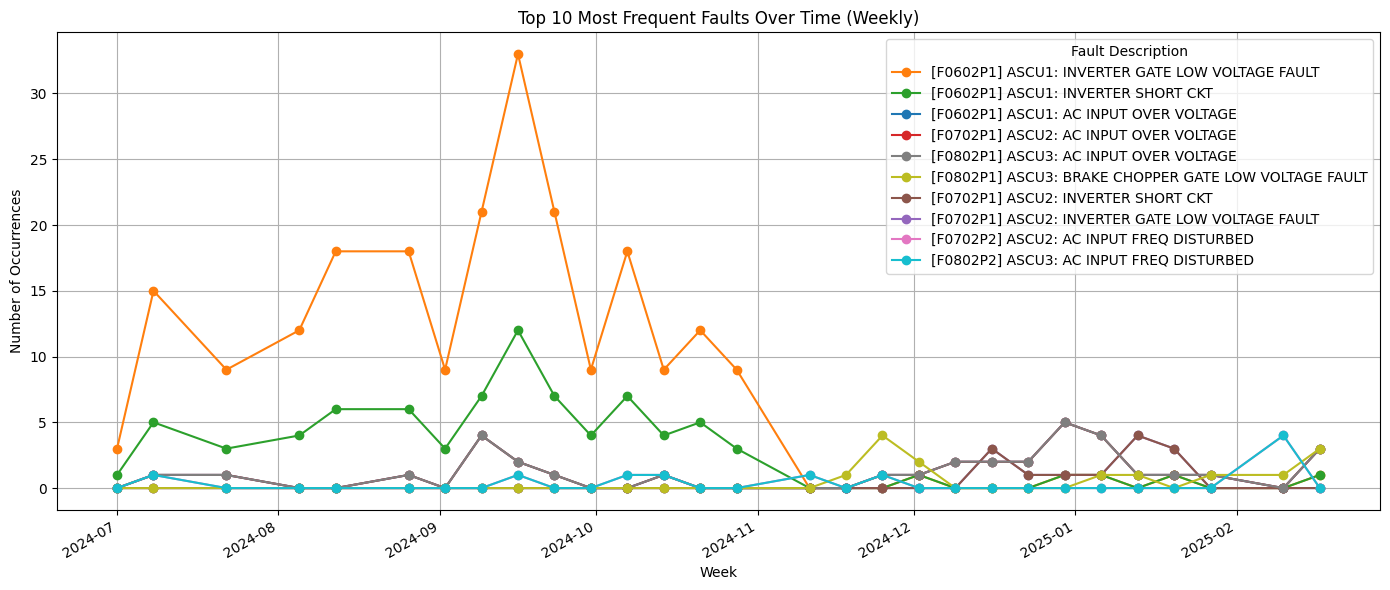

In [25]:
import matplotlib.pyplot as plt

sorted_columns = top10.sum().sort_values(ascending=False)
ax = top10.plot(marker="o", figsize=(14, 6))
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    [dict(zip(labels, handles))[l] for l in totals.index],
    totals.index,
    title="Fault Description",
    loc="upper right",
)

plt.title("Top 10 Most Frequent Faults Over Time (Weekly)")
plt.xlabel("Week")
plt.ylabel("Number of Occurrences")
plt.grid(True)
plt.tight_layout()
plt.show()

## Interactive Plot

In [27]:
import plotly.express as px

sorted_columns = top10.sum().sort_values(ascending=False).index
fig = px.line(
    top10[sorted_columns],
    markers=True,
    title="Top 10 Most Frequent Faults Over Time (Weekly)",
)
fig.update_layout(xaxis_title="Week", yaxis_title="Occurrences")
fig.show()